In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.tail(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
3748,21-03-2024,1035.599976,9903738,6715.750000,1806092,255.699997,10121220,149.949997,6212045,1445.750000,...,1772.150024,3783681,121.050003,38099730,744.299988,15161161,450.250000,18429233,841.599976,987716
3749,22-03-2024,1033.300049,9891194,6760.899902,1125238,259.799988,11402546,149.600006,8409218,1442.849976,...,1776.400024,7061283,122.750000,35001868,746.700012,15535921,460.100006,12531582,861.500000,1618543
3750,26-03-2024,1040.550049,9656767,6910.100098,1850321,261.549988,8259347,149.800003,7742995,1425.400024,...,1753.699951,5303630,123.949997,30860596,740.049988,14678342,461.399994,10475524,858.250000,1391794
3751,27-03-2024,1052.849976,17027308,7022.750000,1551275,258.750000,19196992,149.800003,20853016,1440.699951,...,1775.599976,8231130,122.750000,42673023,733.299988,30088789,445.600006,28138339,840.200012,1344329
3752,28-03-2024,1047.199951,10235318,7245.250000,3574518,264.049988,11966752,150.199997,7208707,1447.900024,...,1785.500000,6630072,124.400002,29453142,752.349976,21705116,451.000000,12637899,849.349976,5261416


In [3]:
feature_columns = ['FEDBANK', 'FEDVOL', 'SBI', 'BAJAJFIN', 'ICICI']
target_column = ['FEDBANK']
features = df[feature_columns]
target = df[target_column].shift(-1)

new_data1 = 152.35
target.iloc[-1, 0] = new_data1

target.tail(5)

,FEDBANK
3748,149.600006
3749,149.800003
3750,149.800003
3751,150.199997
3752,152.350000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

n_steps = 5  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_fedbk1h_0.9837.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9837
MAPE: 0.0220
RMSE: 3.2208
RMSE_normalizeddata: 0.0211
MAE_normalizeddata: 0.0161
MAE: 2.4598


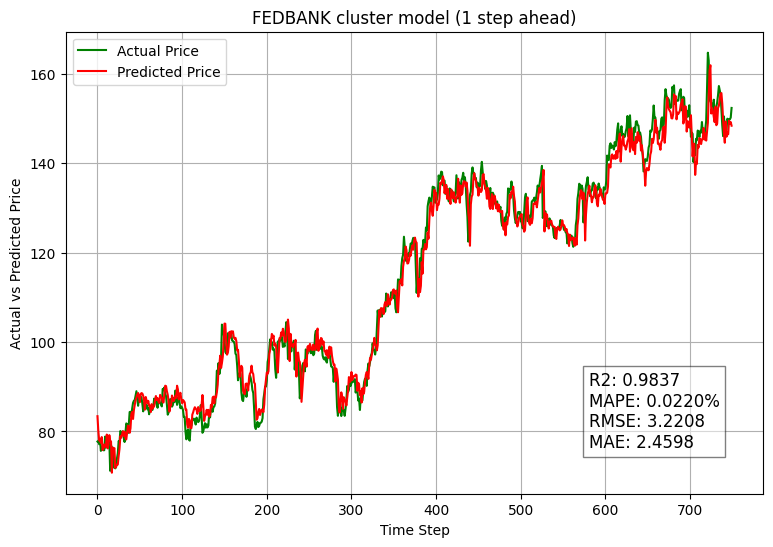

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('FEDBANK cluster model (1 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('fedcluster_1sa1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9937
MAPE: 0.0253
RMSE: 2.0498
RMSE_normalizeddata: 0.0134
MAE_normalizeddata: 0.0092
MAE: 1.4126


In [67]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0111 - val_loss: 6.6811e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6157e-04 - val_loss: 5.6051e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7285e-04 - val_loss: 0.0017
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4597e-04 - val_loss: 5.5651e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3577e-04 - val_loss: 5.8314e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5748e-04 - val_loss: 0.0010
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9450e-04 - val_loss: 5.4157e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8691e-04 - val_loss: 8.1954e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4501e-04 - val_loss: 7.2090e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7587e-04 - val_loss: 5.6724e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss

In [68]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [69]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0144 - val_loss: 8.0247e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4279e-04 - val_loss: 6.1998e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6142e-04 - val_loss: 7.5068e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7222e-04 - val_loss: 5.4513e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2575e-04 - val_loss: 0.0012
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4248e-04 - val_loss: 8.2093e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9106e-04 - val_loss: 5.9055e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1862e-04 - val_loss: 5.4531e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1653e-04 - val_loss: 5.0087e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0949e-04 - val_loss: 6.1967e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

In [70]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [71]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0154 - val_loss: 5.6699e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 3.4122e-04 - val_loss: 0.0017
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8158e-04 - val_loss: 6.8301e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3785e-04 - val_loss: 6.2543e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9391e-04 - val_loss: 0.0010
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9931e-04 - val_loss: 0.0014
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9308e-04 - val_loss: 5.9576e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7420e-04 - val_loss: 0.0034
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4845e-04 - val_loss: 6.4385e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7507e-04 - val_loss: 5.6415e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 

In [72]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [73]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0126 - val_loss: 7.1617e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6836e-04 - val_loss: 6.0196e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9661e-04 - val_loss: 6.5076e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2909e-04 - val_loss: 0.0013
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1258e-04 - val_loss: 8.1177e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5660e-04 - val_loss: 7.0211e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1177e-04 - val_loss: 0.0018
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4885e-04 - val_loss: 7.6043e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8049e-04 - val_loss: 0.0013
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6386e-04 - val_loss: 5.5746e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - los

In [74]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [75]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0131 - val_loss: 0.0011
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.5496e-04 - val_loss: 0.0021
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.9968e-04 - val_loss: 8.8021e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6276e-04 - val_loss: 0.0011
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2852e-04 - val_loss: 6.3676e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5685e-04 - val_loss: 5.6526e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9661e-04 - val_loss: 7.3811e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8328e-04 - val_loss: 6.5190e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8799e-04 - val_loss: 5.4586e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8421e-04 - val_loss: 6.9005e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - l

In [76]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [77]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0097 - val_loss: 0.0018
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9354e-04 - val_loss: 0.0012
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4499e-04 - val_loss: 6.4077e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6901e-04 - val_loss: 7.1140e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5559e-04 - val_loss: 6.2850e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2323e-04 - val_loss: 6.6581e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0492e-04 - val_loss: 0.0014
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1721e-04 - val_loss: 6.0862e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0808e-04 - val_loss: 9.9875e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8585e-04 - val_loss: 6.9861e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 

In [78]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [79]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0149 - val_loss: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4597e-04 - val_loss: 0.0015
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0730e-04 - val_loss: 7.2388e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2706e-04 - val_loss: 0.0013
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3331e-04 - val_loss: 0.0012
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6312e-04 - val_loss: 4.9603e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7968e-04 - val_loss: 4.8165e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3500e-04 - val_loss: 4.8399e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.5436e-04 - val_loss: 5.1432e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7198e-04 - val_loss: 7.2178e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - lo

In [80]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [81]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0135 - val_loss: 8.8919e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2779e-04 - val_loss: 0.0014
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.5593e-04 - val_loss: 7.4181e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.8977e-04 - val_loss: 7.1948e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9662e-04 - val_loss: 0.0012
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.2598e-04 - val_loss: 6.1731e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.5649e-04 - val_loss: 6.4758e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.1758e-04 - val_loss: 5.8147e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5608e-04 - val_loss: 5.5116e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.4249e-04 - val_loss: 6.2057e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/s

In [82]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [83]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.0130 - val_loss: 7.9250e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6846e-04 - val_loss: 6.0132e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4141e-04 - val_loss: 0.0017
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3944e-04 - val_loss: 5.5122e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1212e-04 - val_loss: 5.0392e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1568e-04 - val_loss: 8.6475e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1395e-04 - val_loss: 5.1389e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.9500e-04 - val_loss: 4.8641e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9906e-04 - val_loss: 4.5704e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6415e-04 - val_loss: 4.3398e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 1

In [84]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")

In [85]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0134 - val_loss: 7.5143e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.7107e-04 - val_loss: 7.3314e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3855e-04 - val_loss: 9.8944e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5123e-04 - val_loss: 0.0022
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1501e-04 - val_loss: 6.8066e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.3197e-04 - val_loss: 0.0030
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.3121e-04 - val_loss: 6.3924e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.9634e-04 - val_loss: 5.1334e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9751e-04 - val_loss: 4.9562e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8960e-04 - val_loss: 4.9839e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/

In [86]:
model_lstm.save(f"model_lstm_fedbk1h_{r2:.4f}.keras")